In [ ]:
# !pip3 install torch torchvision

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

from PIL import Image
import torchvision.transforms.functional as TF
import cv2
import random
import os
import rembg.bg as rembg

from scipy.spatial import distance
from scipy.ndimage.filters import convolve
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [7]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, ), (0.5, ))
                               ])


transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
                               ])

training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform = transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform = transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

In [9]:
classes = ['apples', 'aquarium fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottles', 
           'bowls', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'cans', 'castle', 'caterpillar', 'cattle', 'chair', 
           'chimpanzee', 'clock', 'cloud', 'cockroach', 'computer keyboard', 'couch', 'crab', 'crocodile', 
           'cups', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 
           'kangaroo', 'lamp', 'lawn-mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple', 'motorcycle', 
           'mountain', 'mouse', 'mushrooms', 'oak', 'oranges', 'orchids', 'otter', 'palm', 'pears', 'pickup truck', 
           'pine', 'plain', 'plates', 'poppies', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 
           'roses', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 
           'streetcar', 'sunflowers', 'sweet peppers', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
           'train', 'trout', 'tulips', 'turtle', 'wardrobe', 'whale', 'willow', 'wolf', 'woman', 'worm']

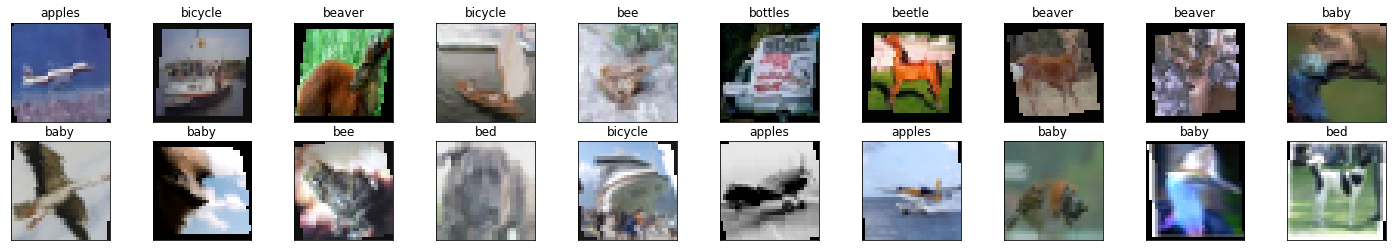

In [10]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [11]:
def get_sparse_neighbor(p: int, n: int, m: int):
    """Returns a dictionnary, where the keys are index of 4-neighbor of `p` in the sparse matrix,
       and values are tuples (i, j, x), where `i`, `j` are index of neighbor in the normal matrix,
       and x is the direction of neighbor.
    Arguments:
        p {int} -- index in the sparse matrix.
        n {int} -- number of rows in the original matrix (non sparse).
        m {int} -- number of columns in the original matrix.
    Returns:
        dict -- dictionnary containing indices of 4-neighbors of `p`.
    """
    i, j = p // m, p % m
    d = {}
    if i - 1 >= 0:
        d[(i - 1) * m + j] = (i - 1, j, 0)
    if i + 1 < n:
        d[(i + 1) * m + j] = (i + 1, j, 0)
    if j - 1 >= 0:
        d[i * m + j - 1] = (i, j - 1, 1)
    if j + 1 < m:
        d[i * m + j + 1] = (i, j + 1, 1)
    return d


def create_spacial_affinity_kernel(spatial_sigma: float, size: int = 15):
    """Create a kernel (`size` * `size` matrix) that will be used to compute the he spatial affinity based Gaussian weights.
    Arguments:
        spatial_sigma {float} -- Spatial standard deviation.
    Keyword Arguments:
        size {int} -- size of the kernel. (default: {15})
    Returns:
        np.ndarray - `size` * `size` kernel
    """
    kernel = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            kernel[i, j] = np.exp(-0.5 * (distance.euclidean((i, j), (size // 2, size // 2)) ** 2) / (spatial_sigma ** 2))

    return kernel


def compute_smoothness_weights(L: np.ndarray, x: int, kernel: np.ndarray, eps: float = 1e-3):
    """Compute the smoothness weights used in refining the illumination map optimization problem.
    Arguments:
        L {np.ndarray} -- the initial illumination map to be refined.
        x {int} -- the direction of the weights. Can either be x=1 for horizontal or x=0 for vertical.
        kernel {np.ndarray} -- spatial affinity matrix
    Keyword Arguments:
        eps {float} -- small constant to avoid computation instability. (default: {1e-3})
    Returns:
        np.ndarray - smoothness weights according to direction x. same dimension as `L`.
    """
    Lp = cv2.Sobel(L, cv2.CV_64F, int(x == 1), int(x == 0), ksize=1)
    T = convolve(np.ones_like(L), kernel, mode='constant')
    T = T / (np.abs(convolve(Lp, kernel, mode='constant')) + eps)
    return T / (np.abs(Lp) + eps)


def fuse_multi_exposure_images(im: np.ndarray, under_ex: np.ndarray, over_ex: np.ndarray,
                               bc: float = 1, bs: float = 1, be: float = 1):
    """perform the exposure fusion method used in the DUAL paper.
    Arguments:
        im {np.ndarray} -- input image to be enhanced.
        under_ex {np.ndarray} -- under-exposure corrected image. same dimension as `im`.
        over_ex {np.ndarray} -- over-exposure corrected image. same dimension as `im`.
    Keyword Arguments:
        bc {float} -- parameter for controlling the influence of Mertens's contrast measure. (default: {1})
        bs {float} -- parameter for controlling the influence of Mertens's saturation measure. (default: {1})
        be {float} -- parameter for controlling the influence of Mertens's well exposedness measure. (default: {1})
    Returns:
        np.ndarray -- the fused image. same dimension as `im`.
    """
    merge_mertens = cv2.createMergeMertens(bc, bs, be)
    images = [np.clip(x * 255, 0, 255).astype("uint8") for x in [im, under_ex, over_ex]]
    fused_images = merge_mertens.process(images)
    return fused_images


def refine_illumination_map_linear(L: np.ndarray, gamma: float, lambda_: float, kernel: np.ndarray, eps: float = 1e-3):
    """Refine the illumination map based on the optimization problem described in the two papers.
       This function use the sped-up solver presented in the LIME paper.
    Arguments:
        L {np.ndarray} -- the illumination map to be refined.
        gamma {float} -- gamma correction factor.
        lambda_ {float} -- coefficient to balance the terms in the optimization problem.
        kernel {np.ndarray} -- spatial affinity matrix.
    Keyword Arguments:
        eps {float} -- small constant to avoid computation instability (default: {1e-3}).
    Returns:
        np.ndarray -- refined illumination map. same shape as `L`.
    """
    # compute smoothness weights
    wx = compute_smoothness_weights(L, x=1, kernel=kernel, eps=eps)
    wy = compute_smoothness_weights(L, x=0, kernel=kernel, eps=eps)

    n, m = L.shape
    L_1d = L.copy().flatten()

    # compute the five-point spatially inhomogeneous Laplacian matrix
    row, column, data = [], [], []
    for p in range(n * m):
        diag = 0
        for q, (k, l, x) in get_sparse_neighbor(p, n, m).items():
            weight = wx[k, l] if x else wy[k, l]
            row.append(p)
            column.append(q)
            data.append(-weight)
            diag += weight
        row.append(p)
        column.append(p)
        data.append(diag)
    F = csr_matrix((data, (row, column)), shape=(n * m, n * m))

    # solve the linear system
    Id = diags([np.ones(n * m)], [0])
    A = Id + lambda_ * F
    L_refined = spsolve(csr_matrix(A), L_1d, permc_spec=None, use_umfpack=True).reshape((n, m))

    # gamma correction
    L_refined = np.clip(L_refined, eps, 1) ** gamma

    return L_refined


def correct_underexposure(im: np.ndarray, gamma: float, lambda_: float, kernel: np.ndarray, eps: float = 1e-3):
    """correct underexposudness using the retinex based algorithm presented in DUAL and LIME paper.
    Arguments:
        im {np.ndarray} -- input image to be corrected.
        gamma {float} -- gamma correction factor.
        lambda_ {float} -- coefficient to balance the terms in the optimization problem.
        kernel {np.ndarray} -- spatial affinity matrix.
    Keyword Arguments:
        eps {float} -- small constant to avoid computation instability (default: {1e-3})
    Returns:
        np.ndarray -- image underexposudness corrected. same shape as `im`.
    """

    # first estimation of the illumination map
    L = np.max(im, axis=-1)
    # illumination refinement
    L_refined = refine_illumination_map_linear(L, gamma, lambda_, kernel, eps)

    # correct image underexposure
    L_refined_3d = np.repeat(L_refined[..., None], 3, axis=-1)
    im_corrected = im / L_refined_3d
    return im_corrected

# TODO: resize image if too large, optimization take too much time

def enhance_image_exposure(im: np.ndarray, gamma: float=0.6, lambda_: float=0.15, dual: bool = True, sigma: int = 3,
                           bc: float = 1, bs: float = 1, be: float = 1, eps: float = 1e-3):
    """Enhance input image, using either DUAL method, or LIME method. For more info, please see original papers.
    Arguments:
        im {np.ndarray} -- input image to be corrected.
        gamma {float} -- gamma correction factor.
        lambda_ {float} -- coefficient to balance the terms in the optimization problem (in DUAL and LIME).
    Keyword Arguments:
        dual {bool} -- boolean variable to indicate enhancement method to be used (either DUAL or LIME) (default: {True})
        sigma {int} -- Spatial standard deviation for spatial affinity based Gaussian weights. (default: {3})
        bc {float} -- parameter for controlling the influence of Mertens's contrast measure. (default: {1})
        bs {float} -- parameter for controlling the influence of Mertens's saturation measure. (default: {1})
        be {float} -- parameter for controlling the influence of Mertens's well exposedness measure. (default: {1})
        eps {float} -- small constant to avoid computation instability (default: {1e-3})
    Returns:
        np.ndarray -- image exposure enhanced. same shape as `im`.
    """
    # create spacial affinity kernel
    kernel = create_spacial_affinity_kernel(sigma)

    # correct underexposudness
    im_normalized = im.astype(float) / 255.
    under_corrected = correct_underexposure(im_normalized, gamma, lambda_, kernel, eps)

    if dual:
        # correct overexposure and merge if DUAL method is selected
        inv_im_normalized = 1 - im_normalized
        over_corrected = 1 - correct_underexposure(inv_im_normalized, gamma, lambda_, kernel, eps)
        # fuse images
        im_corrected = fuse_multi_exposure_images(im_normalized, under_corrected, over_corrected, bc, bs, be)
    else:
        im_corrected = under_corrected

    # convert to 8 bits and returns
    return np.clip(im_corrected * 255, 0, 255).astype("uint8")


def get_under_n_over_channel(im: np.ndarray, gamma: float=0.6, lambda_: float=0.15, dual: bool = True, sigma: int = 3,
                           bc: float = 1, bs: float = 1, be: float = 1, eps: float = 1e-3):
    """Enhance input image, using either DUAL method, or LIME method. For more info, please see original papers.
    Arguments:
        im {np.ndarray} -- input image to be corrected.
        gamma {float} -- gamma correction factor.
        lambda_ {float} -- coefficient to balance the terms in the optimization problem (in DUAL and LIME).
    Keyword Arguments:
        dual {bool} -- boolean variable to indicate enhancement method to be used (either DUAL or LIME) (default: {True})
        sigma {int} -- Spatial standard deviation for spatial affinity based Gaussian weights. (default: {3})
        bc {float} -- parameter for controlling the influence of Mertens's contrast measure. (default: {1})
        bs {float} -- parameter for controlling the influence of Mertens's saturation measure. (default: {1})
        be {float} -- parameter for controlling the influence of Mertens's well exposedness measure. (default: {1})
        eps {float} -- small constant to avoid computation instability (default: {1e-3})
    Returns:
        np.ndarray -- image exposure enhanced. same shape as `im`.
    """
    # create spacial affinity kernel
    kernel = create_spacial_affinity_kernel(sigma)

    # correct underexposudness
    im_normalized = im.astype(float) / 255.
    under_corrected = correct_underexposure(im_normalized, gamma, lambda_, kernel, eps)
    inv_im_normalized = 1 - im_normalized
    over_corrected = 1 - correct_underexposure(inv_im_normalized, gamma, lambda_, kernel, eps)

    under_corrected = np.clip(under_corrected * 255, 0, 255).astype("uint8")
    over_corrected = np.clip(over_corrected * 255, 0, 255).astype("uint8")
    # convert to 8 bits and returns
    return (under_corrected,over_corrected)

In [12]:
class AlphaBgTransform:
    """Adjsut image size based on alpha mask
    Output 224*224*4 ndarray
    """

    def __init__(self, alpha=True):
        self.u2net = rembg.get_model("u2net")
        self.alpha = alpha

    def __call__(self, x):
        if type(x) is Image.Image:
            # conver to opencv image, by default it is RGB or RGBA
            x = np.array(x)

        if x.shape[2] == 3:
            # only 3 channel remove bg and add alpha channel
            x = self.remove_bg(x)

        #crop
        x = AlphaBgTransform.center_crop(x)

        # tosquare
        x = AlphaBgTransform.to_square(x)

        # resize
        # x = cv2.resize(x, (224,224), interpolation = cv2.INTER_AREA)
        x = AlphaBgTransform.resize(x,224)

        # #enhance color
        # x = AlphaBgTransform.enhance_color(x)

        (cu,co) = get_under_n_over_channel(im=x[:,:,:-1])

        # basic transform for the model
        # transform = transforms.Compose([
        #     # transforms.Resize(224),
        #     # transforms.CenterCrop(224),
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean=[0.485, 0.456, 0.406,0.9], std=[0.229, 0.224, 0.225,0.2]),
        # ])
        # x = transform(x)

        #transform changed dimention to 2,0,1 which is 4 * 244 * 244
        if self.alpha is False:
            # return 3 channel ndarray
            # x = x[:-1,:,:]
            x = x[:,:,:-1]

        return x

    @staticmethod
    def resize(x, dim):
        x = cv2.resize(x, (dim,dim), interpolation = cv2.INTER_AREA)
        return x

    def remove_bg(self,
        data,
        alpha_matting=False,
        alpha_matting_foreground_threshold=240,
        alpha_matting_background_threshold=10,
        alpha_matting_erode_structure_size=10,
        alpha_matting_base_size=1000,
        ):
        """The remove bg code is based on: https://github.com/ziyunxiao/rembg
           For Original code and usage please check their Github Repo
        Args:
            data ([type]): [description]
            model_name (str, optional): [description]. Defaults to "u2net".
            alpha_matting (bool, optional): [description]. Defaults to False.
            alpha_matting_foreground_threshold (int, optional): [description]. Defaults to 240.
            alpha_matting_background_threshold (int, optional): [description]. Defaults to 10.
            alpha_matting_erode_structure_size (int, optional): [description]. Defaults to 10.
            alpha_matting_base_size (int, optional): [description]. Defaults to 1000.
        Returns:
            [type]: [description]
        """
        # img = Image.open(io.BytesIO(data)).convert("RGB")
        img = Image.fromarray(data) # input must RGB NDarray
        mask = rembg.detect.predict(self.u2net, np.array(img)).convert("L")
        # mask = rembg.detect.predict(self.u2net, img).convert("L")

        if alpha_matting:
            try:
                cutout = rembg.alpha_matting_cutout(
                    img,
                    mask,
                    alpha_matting_foreground_threshold,
                    alpha_matting_background_threshold,
                    alpha_matting_erode_structure_size,
                    alpha_matting_base_size,
                )
            except:
                cutout = rembg.naive_cutout(img, mask)
        else:
            cutout = rembg.naive_cutout(img, mask)

        return np.array(cutout)

    @staticmethod
    def center_crop(x):
        arr = x[:,:,3]
        idx = np.transpose(np.nonzero(arr))
        h = x.shape[0]
        w = x.shape[1]

        lh = min(idx[:,0]) - 10
        lw = min(idx[:,1]) - 10
        bh = max(idx[:,0]) + 10
        bw = max(idx[:,1]) + 10

        lh = 0 if lh < 0 else lh
        lw = 0 if lw < 0 else lw
        bh = h if bh > h else bh
        bw = w if bw > w else bw

        croped_image = x[lh:bh,lw:bw,:]

        return croped_image

    @staticmethod
    def enhance_color(x):
        x1 = x[:,:,:-1]

        gamma = 0.6
        lambda_ = 0.15
        sigma=3
        bc =1
        bs=1
        be = 1
        eps = 1e-3

        # correct color
        enhanced_image = enhance_image_exposure(x1, gamma, lambda_, dual=True,
                                        sigma=sigma, bc=bc, bs=bs, be=be, eps=eps)

        x[:,:,:-1] = enhanced_image

        return x

    @staticmethod
    def to_square(x):
        (h, w,c) = x.shape

        # padding
        dim = max(h,w)
        img = np.zeros((dim,dim,c),dtype="uint8")

        if h>w:
            s_idx = (h-w)//2
            e_idx = s_idx + w
            img[:,s_idx:e_idx,:] = x
        elif h< w:
            s_idx = (w-h)//2
            e_idx = s_idx + h
            img[s_idx:e_idx,:,:] = x
        else:
            img = x
        return img

class ParameterError(Exception):
    pass

In [13]:
class AlphaLeNet(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(5, 16, 3, 1, padding = 1) # add 2 more channels to original network
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding = 1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding = 1) # when add layers, how the layers are connected and channel values are related
    self.fc1 = nn.Linear(4*4*64, 500) # how to determine the value of 4*4 or 5*5
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)
  def forward(self, x): # be careful the capitalizaiton of x and layers of LeNet
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2) # what does pool2d mean? 2?
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x) 
      x = self.fc2(x)
      return x

In [14]:
model = AlphaLeNet().to(device)
model

AlphaLeNet(
  (conv1): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # try different learning rates to see how model works, lower learning rate cause overfiting

In [16]:
epochs = 30
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)


  else:
    with torch.no_grad():
     for val_inputs, val_labels in validation_loader:
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)

      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)


    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch:', (e+1))
    print('training loss: {:.4f}, acc{:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

RuntimeError: Given groups=1, weight of size [16, 5, 3, 3], expected input[100, 3, 32, 32] to have 5 channels, but got 3 channels instead

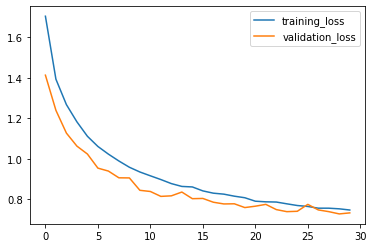

In [12]:
plt.plot(running_loss_history, label = "training_loss")
plt.plot(val_running_loss_history, label = "validation_loss")
plt.legend()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

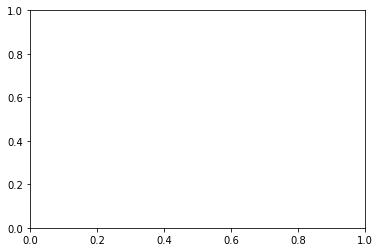

In [13]:
plt.plot(running_corrects_history, label = "training_accuracy")
plt.plot(val_running_corrects_history, label = "validation_accuracy")
plt.legend()

In [14]:
!pip3 install pillow==5.2.0

  Using cached Pillow-5.2.0.tar.gz (14.5 MB)
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for pillow, since package 'wheel' is not installed.
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.3.2
    Uninstalling Pillow-8.3.2:
      Successfully uninstalled Pillow-8.3.2
    Running setup.py install for pillow ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
matplotlib 3.5.0 requires pillow>=6.2.0, but you have pillow 5.2.0 which is incompatible.
imageio 2.11.1 requires pillow>=8.3.2, but you have pillow 5.2.0 which is incompatible.


In [15]:
import PIL.ImageOps

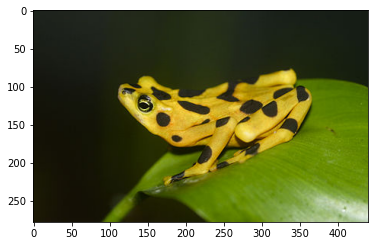

In [16]:
import requests
from PIL import Image

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Atelopus_zeteki1.jpg/440px-Atelopus_zeteki1.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

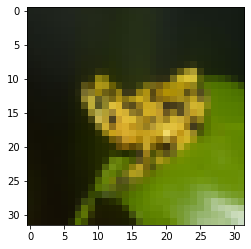

In [17]:
img = transform(img)
plt.imshow(im_convert(img))

In [18]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bee


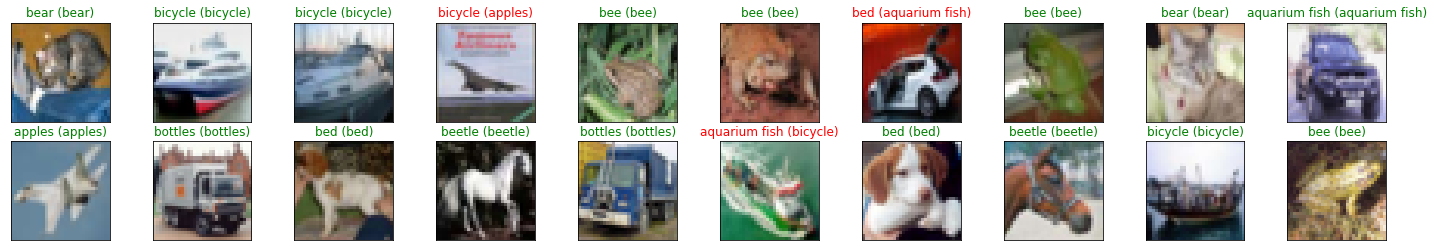

In [19]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
lables = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ("green" if preds[idx]==labels[idx] else "red"))